In [1]:
!pip3 install catboost

In [2]:
import pandas as pd 
import warnings
import numpy as np
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,RobustScaler
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import lightgbm as lgb
from learntools.core import *

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [4]:
titanic_train=pd.read_csv(r'/kaggle/input/nbbbbb/train.csv', sep=',')

In [5]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
titanic_test=pd.read_csv(r'/kaggle/input/nbbbbb/test.csv', sep=',')
y_test=pd.read_csv(r'/kaggle/input/nbbbbb/sample_submission.csv', sep=',')

In [7]:
plot_df = titanic_train.Transported
plot_df

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [8]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [9]:
titanic_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4186.0,28.658146,14.179072,0.0,19.0,26.0,37.0,79.0
RoomService,4195.0,219.266269,607.011289,0.0,0.0,0.0,53.0,11567.0
FoodCourt,4171.0,439.484296,1527.663045,0.0,0.0,0.0,78.0,25273.0
ShoppingMall,4179.0,177.295525,560.821123,0.0,0.0,0.0,33.0,8292.0
Spa,4176.0,303.052443,1117.186015,0.0,0.0,0.0,50.0,19844.0
VRDeck,4197.0,310.710031,1246.994742,0.0,0.0,0.0,36.0,22272.0


In [10]:
titanic_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## предпобработка

In [11]:
titanic_train = titanic_train.drop(['PassengerId', 'Name'], axis=1)
titanic_test=titanic_test.drop('Name',axis=1)

In [12]:
def duplicates(data):
    for i in titanic_train.columns:
        if titanic_train[i].dtype=="object":
            print( titanic_train[i].value_counts())

In [13]:
duplicates(titanic_train)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
VIP
False    8291
True      199
Name: count, dtype: int64


In [14]:
frequents=["HomePlanet","CryoSleep","Destination","VIP"]

In [15]:
passt=["Name","Cabin"]

In [16]:
zeroes=["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
medians=["Age"]

In [17]:
def imput(data):
    for i in data[zeroes].columns:
        data[i]=data[i].fillna(0)
    for y in data[frequents].columns:
        data[y]=data[y].fillna(data[y].mode()[0])
    data["Age"]=data["Age"].fillna(data["Age"].median())

In [18]:
imput(titanic_train)

/tmp/ipykernel_18/537696449.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[y]=data[y].fillna(data[y].mode()[0])


In [19]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8494 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(3)
memory usage: 636.8+ KB


In [20]:
imput(titanic_test)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4277 non-null   bool   
 3   Cabin         4177 non-null   object 
 4   Destination   4277 non-null   object 
 5   Age           4277 non-null   float64
 6   VIP           4277 non-null   bool   
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
dtypes: bool(2), float64(6), object(4)
memory usage: 342.6+ KB


/tmp/ipykernel_18/537696449.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[y]=data[y].fillna(data[y].mode()[0])


In [21]:
titanic_train[["Deck", "Cabin_num", "Side"]] = titanic_train["Cabin"].str.split("/", expand=True)
titanic_train=titanic_train.drop('Cabin',axis=1)
titanic_test[["Deck", "Cabin_num", "Side"]] = titanic_test["Cabin"].str.split("/", expand=True)
titanic_test=titanic_test.drop('Cabin',axis=1)

## Исследование данных

In [22]:
cat_columns=[]
num_columns=[]
print(cat_columns)

[]


In [23]:
def statistic(df):
    names=df.columns
    for i in names:
        st=df[i]
        if df[i].dtype=="object":
            df[i].value_counts().plot(kind="pie")
            plt.show()
            cat_columns.append(i)
        elif df[i].dtype=='int' or df[i].dtype=='float':
            sns.boxplot(data=df,y=i,)
            plt.show()
            num_columns.append(i)

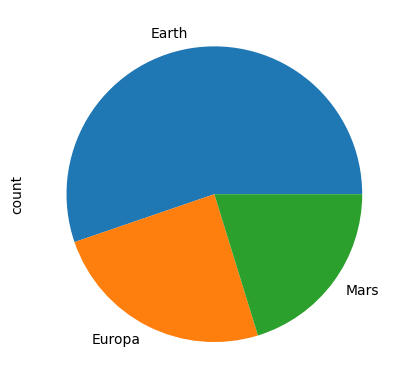

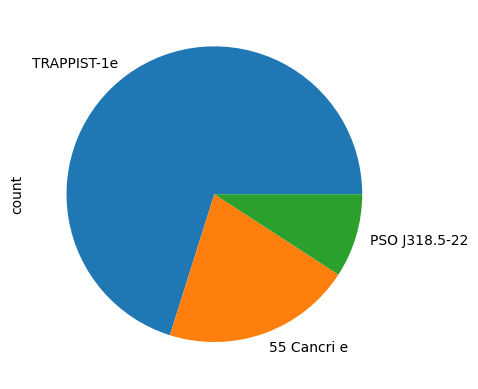

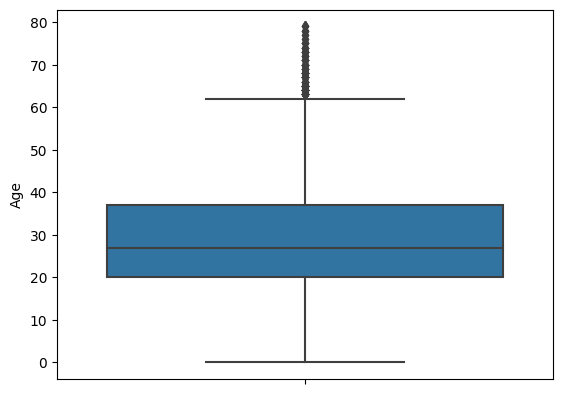

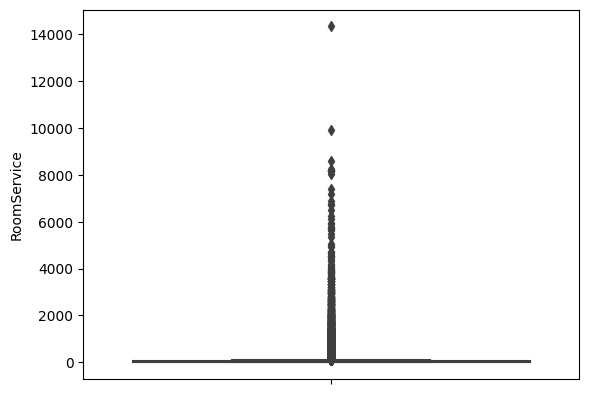

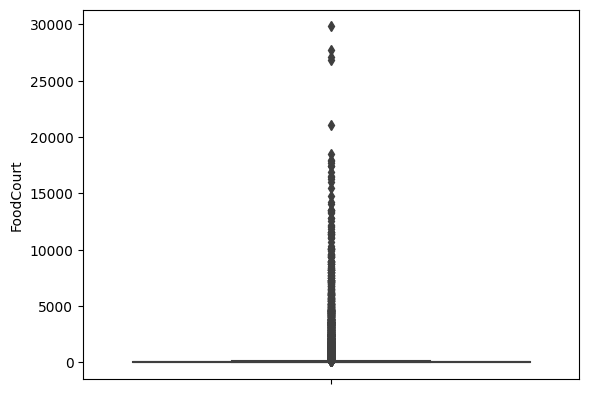

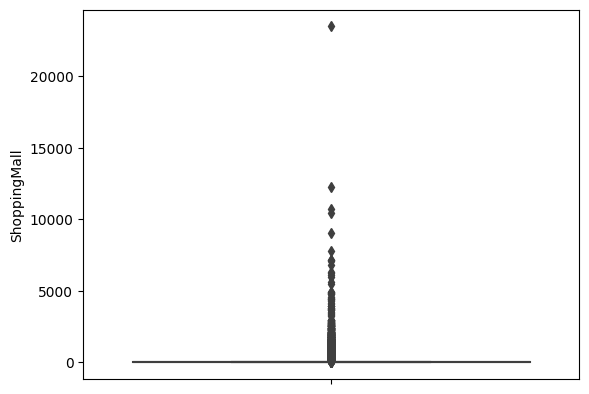

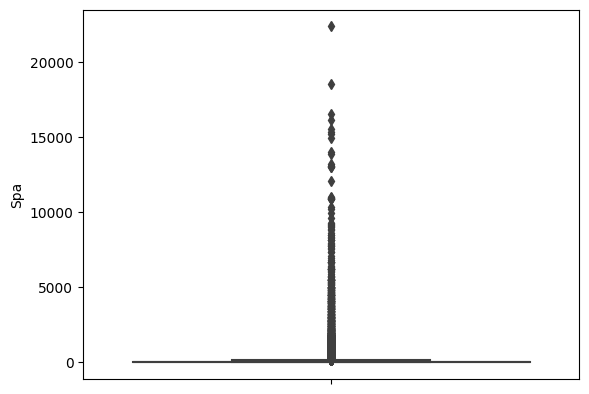

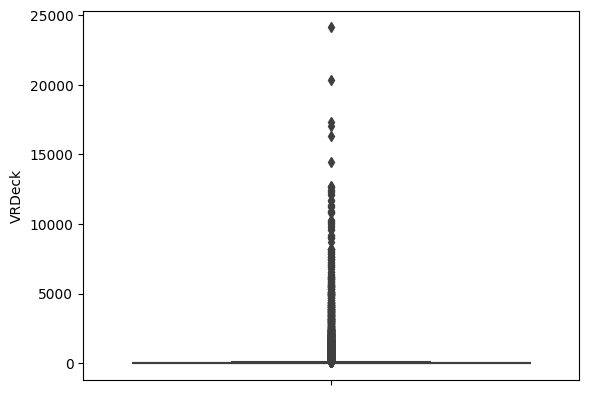

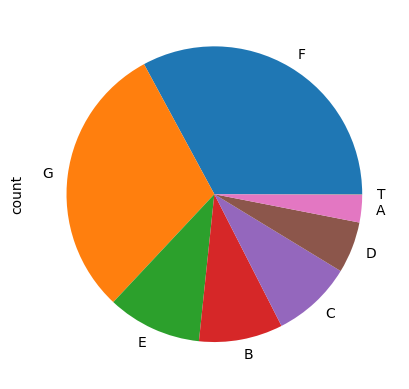

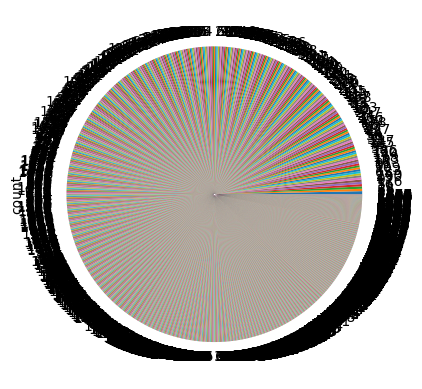

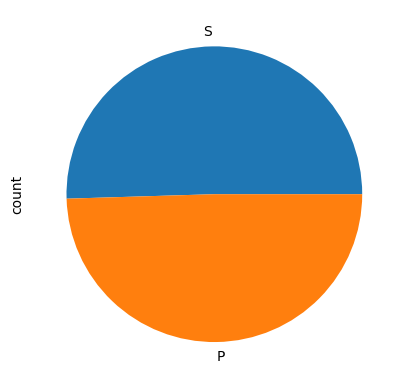

In [24]:
statistic(titanic_train)

## модель и тра та та

In [25]:
X_train=titanic_train.drop('Transported',axis=1)
y_train=titanic_train['Transported']

In [26]:
titanic_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


In [27]:
titanic_test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,G,1496,S
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,NaN,NaN
4274,9271_01,Mars,True,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,D,296,P
4275,9273_01,Europa,False,TRAPPIST-1e,26.0,False,0.0,2680.0,0.0,0.0,523.0,D,297,P


In [28]:
pipe_str = Pipeline(
    [
        (
            'simpleImputer_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder( handle_unknown='ignore')
        ),
        (
            'simpleImputer_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [29]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_str, cat_columns),
        ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [30]:
X_train_transformed=data_preprocessor.fit_transform(X_train)
train_dataset = lgb.Dataset(X_train_transformed, y_train,params={'verbose': -1})
booster = lgb.train({"objective": "binary",'verbose': -1},
                        train_set=train_dataset)

In [31]:
X_test_transformed=data_preprocessor.transform(titanic_test)

In [32]:
test_dataset = lgb.Dataset(X_test_transformed,params={'verbose': -1})

In [33]:
random_state=42

In [34]:
Pipe_final=Pipeline(
    [
      ('preprocessor',data_preprocessor),
      ('models', LogisticRegression(random_state=random_state)) 
    ]
)

In [35]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
Pipe_final.fit(X_train,y_train)
print(accuracy_score(Pipe_final.predict(titanic_test),y_test['Transported']))

0.46200607902735563


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
output = pd.DataFrame(Pipe_final.predict(titanic_test))
output=pd.DataFrame({'PassengerId': titanic_test['PassengerId'],'Transported': Pipe_final.predict(titanic_test)})
output.to_csv('submission.csv', index=False)

In [37]:
print(accuracy_score(output['Transported'],y_test['Transported']))

0.46200607902735563


In [38]:
f=booster.predict(X_test_transformed)
f=pd.DataFrame(f)
f=f.where(f>(1/2), False)
f=f.where(f==False,True)

In [39]:
f[0]=f[0].astype(bool)
output=pd.DataFrame({'PassengerId': titanic_test['PassengerId'],'Transported': f[0]})
output.to_csv('submission.csv', index=False)


In [40]:
print(accuracy_score(f,y_test['Transported']))

0.4786064998830956
